In [1]:
import numpy as np
import pylab as pl
import math as ma
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator
import subprocess
import os
%matplotlib inline
import string,re,sys

# Steps to compile zdcf fortran code on mac:

* For zdcf code f77: gfortran -o zdcf_compiled_name zdcf_v1.2.f
* For zdcf code f95: gfortran -g -fcheck=all -Wall -o zdcf_bin_rs7 zdcf_v1.2.f95


* For the partner maxlike code f77: gfortran -w -fno-automatic -o maxlike_compiled_name plike_v3.0.f
* For the partner maxlike code f95: gfortran -O3 -o plike plike_v4.0.f95


# To execute through python (recommended):

In [2]:
#load lightcurves into arrays

path_dir='/path/to/files/'
bands='insert label here'


data1=np.loadtxt(path_dir+'file1.txt')#higher frequency
data2=np.loadtxt(path_dir+'file2.txt')#lower frequency

day_1=(data1[:,0])
flux_1=data1[:,1]
fluxerr_1=data1[:,2]
day_2=(data2[:,0])
flux_2=data2[:,1]
fluxerr_2=data2[:,2]


<ErrorbarContainer object of 3 artists>

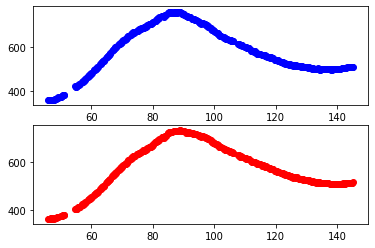

In [3]:
#plot lightcurves to double check data we will input into the CCF code
fig=plt.figure()
ax=plt.subplot(211)
ax.errorbar(day_1,flux_1,yerr=fluxerr_1,marker='o',ls='',color='b')
ax2=plt.subplot(212,sharex=ax)
ax2.errorbar(day_2,flux_2,yerr=fluxerr_2,marker='o',ls='',color='r')

In [5]:
# run zdcf code through python using subprocess module

#set up lightcurve files in proper format needed for the CCF code. Here we write the lightcurve data
#into temporary files for the CCF code to use.
os.system('rm -rf '+path_dir+'inp1')
os.system('rm -rf '+path_dir+'inp1')
os.system('rm -rf '+path_dir+'zdcf_light.dcf')
os.system('rm -rf '+path_dir+'zdcf_light.lc1')
os.system('rm -rf '+path_dir+'zdcf_light.lc2')
tempFile = open(path_dir+'inp1','w')
tempFile2 = open(path_dir+'inp2','w')
for i in range(0,(len(day_1))):
    tempFile.write(' {0} {1} {2}\n'.format((day_1[i]),flux_1[i],fluxerr_1[i]))
for i in range(0,(len(day_2))):
    tempFile2.write(' {0} {1} {2}\n'.format((day_2[i]),flux_2[i],fluxerr_2[i]))
tempFile.close()
tempFile2.close()

#run compiled fortran code
print('Running ZDCF...')
'''subprocess arguments:
-compiled code path
-type (1=auto, 2=cross)
-output files prefix 
-uniform sampling? (y or n)
-min points per bin (11 is default)
-omit zero lag? (y or n)
-mc sim number for errors
-input lc files
-binning parameter (should not need to change this)'''
rc=subprocess.call(['/path/to/compiled/code','2', path_dir+'zdcf_light', 'n',\
                    '11', 'n', '100', path_dir+'inp1', path_dir+'inp2','0.001'])


Running ZDCF...


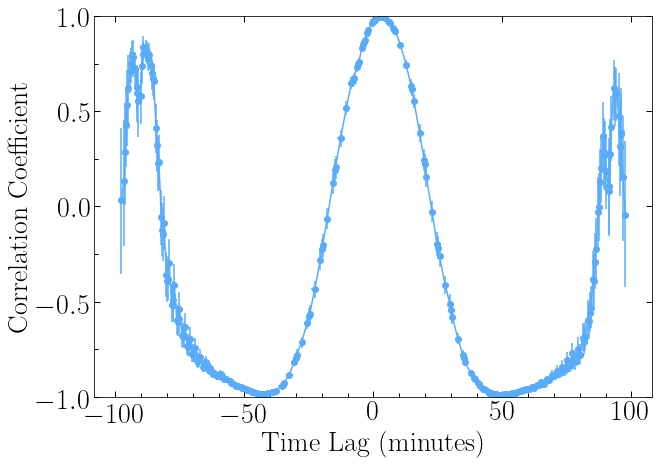

In [8]:
#save output CCF from fortrn code into arrays and write output to a file for reproducability of plots later
data=np.loadtxt(path_dir+'zdcf_light.dcf')
time_lag=data[:,0]
time_lag_low=data[:,1]
time_lag_up=data[:,2]
cross_cor_coef=data[:,3]
cross_cor_coef_low=data[:,4]
cross_cor_coef_up=data[:,5]
filez=open(path_dir+'datafile_zdcf_'+bands+'.txt','w')
for ii in range(0,len(time_lag)):
    filez.write('{0} {1} {2} {3} {4} {5}\n'.format(time_lag[ii],time_lag_low[ii],time_lag_up[ii],\
                                                   cross_cor_coef[ii],cross_cor_coef_low[ii],cross_cor_coef_up[ii]))
filez.close()

#plot your resulting CCF
#time units will be whatever units the input lightcurves are in (here its minutes)
fig2=plt.figure(figsize=(10,7))
from matplotlib import rc
rc('text', usetex=True)
font = {'family' : 'serif',
        'weight' : 'bold',
        'size'   : '14'}
rc('font', **font)
ax=plt.subplot(111)
ax.errorbar(time_lag,cross_cor_coef,yerr=[cross_cor_coef_low,cross_cor_coef_up],xerr=[time_lag_low,time_lag_up],marker='o',color='#58ACFA')
ax.set_xlabel('Time Lag (minutes)',fontsize=28)
ax.set_ylabel('Correlation Coefficient',fontsize=28)
ax.tick_params(axis='both',which='minor',length=4,width=1,direction='in')
ax.tick_params(axis='x',which='major',labelsize=28,length=6,width=1,direction='in',top='on')
ax.tick_params(axis='y',which='major',labelsize=28,length=6,width=1,direction='in',right='on')
#ax.set_xlim(low,up)
ax.set_ylim(-1,1.)
ax.xaxis.set_minor_locator(AutoMinorLocator(5))
ax.yaxis.set_minor_locator(AutoMinorLocator(2))
